In [2]:
import torch
import numpy as np
import matplotlib.pyplot as plt
from torch import nn
import sklearn
import pandas as pd
import json
import nltk
from tqdm.auto import tqdm
import re

/root/repos/pytorch-learn/.venv/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
nltk.download('punkt')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [4]:
device = "cuda" if torch.cuda.is_available() else "cpu"

In [5]:
with open("../data/wiki/00c2bfc7-57db-496e-9d5c-d62f8d8119e3.json") as f:
    data = json.load(f)
    
print(data[0].keys())

dict_keys(['id', 'text', 'title'])


In [6]:
all_words = set()
for x in tqdm(data):
    reg_txt = re.sub(r'[^a-zA-Z\s]', ' ', x['text'])
    reg_txt = re.sub(r"\s+", " ", reg_txt)
    reg_txt = reg_txt.strip()
    x['text'] = nltk.tokenize.word_tokenize(reg_txt)
    all_words.update(x['text'])

list(all_words)[:10]

100%|██████████| 9982/9982 [00:17<00:00, 571.75it/s]


['Broadcasts',
 'SDHB',
 'Rickettsia',
 'Comiccritique',
 'Straume',
 'ophthalmologist',
 'Switzer',
 'Martino',
 'Emanual',
 'Rizzi']

In [7]:
data[0]['text']

['M',
 'was',
 'a',
 'state',
 'trunkline',
 'highway',
 'in',
 'the',
 'US',
 'state',
 'of',
 'Michigan',
 'that',
 'served',
 'as',
 'a',
 'spur',
 'route',
 'to',
 'the',
 'Interlochen',
 'Center',
 'for',
 'the',
 'Arts',
 'and',
 'Interlochen',
 'State',
 'Park',
 'It',
 'started',
 'south',
 'of',
 'the',
 'park',
 'and',
 'ran',
 'north',
 'between',
 'two',
 'lakes',
 'in',
 'the',
 'area',
 'and',
 'through',
 'the',
 'community',
 'of',
 'Interlochen',
 'to',
 'US',
 'Highway',
 'US',
 'in',
 'Grand',
 'Traverse',
 'County',
 'The',
 'highway',
 'was',
 'first',
 'shown',
 'without',
 'a',
 'number',
 'label',
 'on',
 'maps',
 'in',
 'and',
 'labeled',
 'after',
 'an',
 'extension',
 'the',
 'next',
 'year',
 'The',
 'highway',
 's',
 'current',
 'routing',
 'was',
 'established',
 'in',
 'the',
 's',
 'Jurisdiction',
 'of',
 'the',
 'roadway',
 'was',
 'transferred',
 'from',
 'the',
 'Michigan',
 'Department',
 'of',
 'Transportation',
 'MDOT',
 'to',
 'the',
 'Grand',
 'T

In [8]:
len(all_words)

220641

In [9]:
# filter out where there is length 0f 0
data = [x for x in data if len(x['text']) > 0]

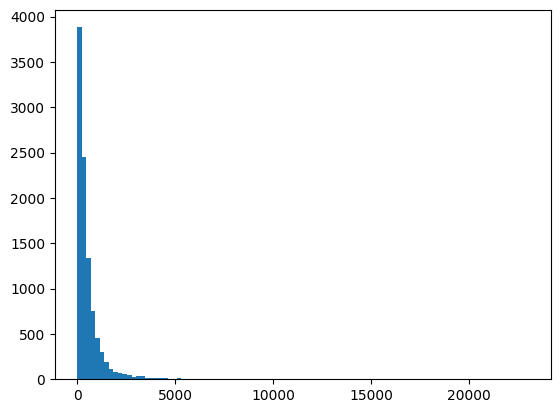

In [10]:
y = [len(x['text']) for x in data]
# hist of y
plt.hist(y, bins=100)
plt.show()

In [11]:
str_to_token = {word: i for i, word in enumerate(all_words)}
token_to_str = {i: word for i, word in enumerate(all_words)}
tokenizer = lambda x: [str_to_token[word] for word in x]
detokenizer = lambda x: [token_to_str[word] for word in x]

first_few = data[0]['text'][:20]
print(f"first ten works {first_few}")
print(f"first ten tokens {tokenizer(first_few)}")
print(f"first ten detokens {detokenizer(tokenizer(first_few))}")


first ten works ['M', 'was', 'a', 'state', 'trunkline', 'highway', 'in', 'the', 'US', 'state', 'of', 'Michigan', 'that', 'served', 'as', 'a', 'spur', 'route', 'to', 'the']
first ten tokens [181569, 81639, 98890, 189981, 212569, 170840, 72624, 135538, 15430, 189981, 114917, 12119, 39032, 66797, 149604, 98890, 211670, 50239, 174759, 135538]
first ten detokens ['M', 'was', 'a', 'state', 'trunkline', 'highway', 'in', 'the', 'US', 'state', 'of', 'Michigan', 'that', 'served', 'as', 'a', 'spur', 'route', 'to', 'the']


In [12]:
CONTEXT_WINDOW = 40

In [13]:
# take chunks of exactly CONTEXT_WINDOW words and chuck everything else and flatten to a single list of these
examples = [tokenizer(x['text'][i:i+CONTEXT_WINDOW]) for x in data for i in range(0, len(x['text']), CONTEXT_WINDOW) if i+CONTEXT_WINDOW < len(x['text'])]

In [14]:
examples[0]

[181569,
 81639,
 98890,
 189981,
 212569,
 170840,
 72624,
 135538,
 15430,
 189981,
 114917,
 12119,
 39032,
 66797,
 149604,
 98890,
 211670,
 50239,
 174759,
 135538,
 117385,
 75520,
 71293,
 135538,
 13616,
 15489,
 117385,
 33749,
 53403,
 21785,
 144493,
 178513,
 114917,
 135538,
 188682,
 15489,
 108446,
 57652,
 189542,
 127685]

In [15]:
torch.tensor(examples).shape

torch.Size([141712, 40])

In [16]:
class CustomDataset(torch.utils.data.Dataset):
    def __init__(self, data):
        self.data = torch.tensor(data, dtype=torch.long, device=device)

    def __len__(self):
        return len(self.data) * CONTEXT_WINDOW

    def __getitem__(self, index):
        example_idx = index // CONTEXT_WINDOW
        inside_example_idx = index % CONTEXT_WINDOW
        x = torch.zeros(CONTEXT_WINDOW, dtype=torch.long, device=device)
        x[:inside_example_idx] = self.data[example_idx][:inside_example_idx]
        y = self.data[example_idx][inside_example_idx]
        return x, y

In [17]:
split = int(0.8 * len(examples))
# shuffle order first
# examples = sklearn.utils.shuffle(examples)
train_rows = examples[:split]
test_rows = examples[split:]
len(train_rows), len(test_rows)

(113369, 28343)

In [18]:
train_data = CustomDataset(train_rows)
test_data = CustomDataset(test_rows)

len(train_data), len(test_data)

(4534760, 1133720)

In [36]:
# sample a random train data point
i = np.random.randint(len(train_data))
x, y = train_data[i]
x, y

(tensor([135538, 167818, 108687, 174206, 164572, 104070,  46747, 128245,  32617,
          97354, 220571, 211668, 172170, 133712, 167818, 149604,  92699,  51240,
          15489, 220606, 212501, 123561, 161878, 128245,  97354,  30469, 205749,
          39263,  53700, 199669,  91734,  33894, 190576, 114917,      0,      0,
              0,      0,      0,      0]),
 tensor(135538))

In [20]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=3, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=3, shuffle=False)

train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([3, 40]), torch.Size([3]))

In [21]:
x = torch.ones((3,40), dtype=torch.long, device=device)
embedding = nn.Embedding(len(all_words), 100)
embedding(x).shape

torch.Size([3, 40, 100])

In [22]:
class CustomModel(nn.Module):
    def __init__(
        self, input_shape: int, embedding_dim: int, hidden_units: int, output_shape: int
    ) -> None:
        super().__init__()
        self.embedding = nn.Embedding(
            num_embeddings=input_shape, embedding_dim=embedding_dim
        )
        self.layer_stack = nn.Sequential(
            nn.Linear(in_features=embedding_dim, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=hidden_units),
            nn.ReLU(),
        )
        # concat all of them at this point then final linear to categories
        self.final_layer = nn.Linear(in_features=hidden_units*CONTEXT_WINDOW, out_features=output_shape)

    def forward(self, x):
        x = self.embedding(x)
        x = self.layer_stack(x)
        x = x.view(x.shape[0], -1)
        x = self.final_layer(x)
        return x

In [23]:
model_0 = CustomModel(
    input_shape=len(all_words),
    embedding_dim=100,
    hidden_units=100,
    output_shape=len(all_words),
).to(device)

In [24]:
from torch.utils.tensorboard import SummaryWriter

writer = SummaryWriter("../runs/transformer")

In [44]:
# make example prediction

model_0.eval()
with torch.inference_mode():
    for X, y in test_dataloader:
        y_preds = model_0(X)
        print(X.shape, y_preds.shape, y.shape)
        print(y_preds[:, :10])
        break

torch.Size([3, 40]) torch.Size([3, 220641]) torch.Size([3])
tensor([[ 0.0667, -0.0909, -0.2069,  0.0271, -0.1068,  0.1513,  0.1213,  0.0205,
         -0.1400,  0.0833],
        [ 0.0774, -0.0883, -0.2280,  0.0302, -0.0853,  0.1230,  0.1268,  0.0146,
         -0.1510,  0.0799],
        [ 0.0779, -0.0830, -0.2167,  0.0357, -0.1006,  0.1288,  0.1291,  0.0225,
         -0.1413,  0.0775]])


In [25]:
def train_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_fn,
):
    train_loss, train_acc = 0, 0
    for X, y in tqdm(dataloader):
        model.train()
        y_logits = model(X)
        y_preds = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
        loss = loss_fn(y_logits, y)
        acc = accuracy_fn(y_true=y, y_pred=y_preds)

        train_loss += loss.item()
        train_acc += acc

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    train_loss /= len(dataloader)
    train_acc /= len(dataloader)

    return train_loss, train_acc

In [26]:
def test_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    accuracy_fn,
):
    test_loss, test_acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in tqdm(dataloader):
            y_logits = model(X)
            y_preds = torch.argmax(torch.softmax(y_logits, dim=1), dim=1)
            loss = loss_fn(y_logits, y)
            acc = accuracy_fn(y_true=y, y_pred=y_preds)

            test_loss += loss.item()
            test_acc += acc

    test_loss /= len(dataloader)
    test_acc /= len(dataloader)

    return test_loss, test_acc

In [27]:
from sklearn.metrics import accuracy_score
from tqdm.auto import tqdm


def train_model(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    optimizer: torch.optim.Optimizer,
    accuracy_score: callable,
    epochs: int = 3,
) -> dict[str, list[float]]:

    results = {
        "train_loss": [],
        "train_acc": [],
        "test_loss": [],
        "test_acc": [],
    }
    for epoch in tqdm(range(epochs)):

        train_loss, train_acc = train_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            optimizer=optimizer,
            accuracy_fn=accuracy_score,
        )

        test_loss, test_acc = test_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            accuracy_fn=accuracy_score,
        )

        results["train_loss"].append(train_loss)
        results["train_acc"].append(train_acc)
        results["test_loss"].append(test_loss)
        results["test_acc"].append(test_acc)

    return results

In [28]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(params=model_0.parameters(), lr=0.1)

model_0_train_results = train_model(
    model=model_0,
    train_dataloader=train_dataloader,
    test_dataloader=test_dataloader,
    loss_fn=loss_fn,
    optimizer=optimizer,
    accuracy_score=accuracy_score,
    epochs=1,
)

  0%|          | 0/1 [00:00<?, ?it/s]

: 

In [ ]:
writer = SummaryWriter("../runs/model_0")

for epoch in range(len(model_0_train_results["train_loss"])):
    writer.add_scalars(
        "loss",
        {
            "train_loss": model_0_train_results["train_loss"][epoch],
            "test_loss": model_0_train_results["test_loss"][epoch],
        },
        epoch,
    )
    writer.add_scalars(
        "accuracy",
        {
            "train_acc": model_0_train_results["train_acc"][epoch],
            "test_acc": model_0_train_results["test_acc"][epoch],
        },
        epoch,
    )

writer.close()

In [ ]:
plt.figure(figsize=(12, 6))

# Plotting loss and accuracy
for i, metric in enumerate(["loss", "acc"]):
    plt.subplot(1, 2, i + 1)
    for key in model_0_train_results:
        if metric in key:
            plt.plot(
                range(len(model_0_train_results[key])),
                model_0_train_results[key],
                label=key,
            )
    plt.xlabel("Epoch")
    plt.ylabel(metric.capitalize())
    plt.title(f"Train {metric.capitalize()}")
    plt.legend()

plt.tight_layout()
plt.show()